In [1]:
%%bigquery --use_rest_api train_data
select * from `research_articles.train_split`

Downloading: 100%|██████████| 16828/16828 [00:04<00:00, 4062.18rows/s]


In [2]:
%%bigquery --use_rest_api val_data
select * from `research_articles.val_split`

Downloading: 100%|██████████| 4144/4144 [00:01<00:00, 3334.74rows/s]


In [56]:
import datetime
import os
import shutil

import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from google.cloud import aiplatform
from official.nlp import optimization  # to create AdamW optmizer
import tqdm
from sklearn.metrics import confusion_matrix,precision_score,recall_score,roc_curve,auc,f1_score,accuracy_score
import pandas

tf.get_logger().setLevel("ERROR")

In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))

Num GPUs Available:  1


2023-06-16 05:33:01.047460: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-16 05:33:01.059656: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-16 05:33:01.061250: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [5]:
# defining the URL of the smallBERT model to use
tfhub_handle_encoder = (
    "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1"
)

# defining the corresponding preprocessing model for the BERT model above
tfhub_handle_preprocess = (
    "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
)

print(f"BERT model selected           : {tfhub_handle_encoder}")
print(f"Preprocess model auto-selected: {tfhub_handle_preprocess}")


BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [6]:
def build_classifier_model(dropout_rate=0.1):
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name="text")
    preprocessing_layer = hub.KerasLayer(
        tfhub_handle_preprocess, name="preprocessing"
    )
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(
        tfhub_handle_encoder, trainable=True, name="BERT_encoder"
    )
    outputs = encoder(encoder_inputs)
    net = outputs["pooled_output"]
    net = tf.keras.layers.Dropout(dropout_rate)(net)
    net = tf.keras.layers.Dense(6, activation="sigmoid", name="classifier")(net)
    return tf.keras.Model(text_input, net)


# Let's check that the model runs with the output of the preprocessing model.
dropout_rate = 0.15
classifier_model = build_classifier_model(dropout_rate)



2023-06-16 05:33:06.341880: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-16 05:33:06.342544: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-16 05:33:06.344390: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-16 05:33:06.345931: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [7]:
classifier_model(tf.constant(["hello"]))

<tf.Tensor: shape=(1, 6), dtype=float32, numpy=
array([[0.48925614, 0.80376226, 0.2781035 , 0.328944  , 0.5445536 ,
        0.5458405 ]], dtype=float32)>

In [8]:
loss = tf.keras.losses.BinaryCrossentropy()
metrics = tf.metrics.BinaryAccuracy()

In [9]:
epochs = 5
steps_per_epoch = train_data.shape[0]
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1 * num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(
    init_lr=init_lr,
    num_train_steps=num_train_steps,
    num_warmup_steps=num_warmup_steps,
    optimizer_type="adamw",
)

In [10]:
classifier_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [11]:
X_train = []
for id in train_data.index:
    title = train_data['TITLE'][id]
    abstract = train_data['ABSTRACT'][id].replace("\n"," ")
    X_train.append(". ".join([title,abstract]))
   
X_train = tf.convert_to_tensor( X_train)

In [12]:
Y_train = []
for id in train_data.index:
    Y_train.append([
        train_data['Computer_Science'][id], 
        train_data['Physics'][id], 
        train_data['Mathematics'][id], 
        train_data['Statistics'][id], 
        train_data['Quantitative_Biology'][id], 
        train_data['Quantitative_Finance'][id]
        ]
    )

Y_train = tf.convert_to_tensor( Y_train)

In [13]:
print(f"Training model with {tfhub_handle_encoder}")
history = classifier_model.fit(X_train, Y_train, epochs=epochs, batch_size=32)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/5
526/526 [==============================] - 118s 214ms/step - loss: 0.4928 - binary_accuracy: 0.7547
Epoch 2/5
526/526 [==============================] - 114s 216ms/step - loss: 0.2830 - binary_accuracy: 0.8854
Epoch 3/5
526/526 [==============================] - 114s 217ms/step - loss: 0.2302 - binary_accuracy: 0.9081
Epoch 4/5
526/526 [==============================] - 114s 218ms/step - loss: 0.2067 - binary_accuracy: 0.9164
Epoch 5/5
526/526 [==============================] - 114s 217ms/step - loss: 0.1902 - binary_accuracy: 0.9227


In [68]:
history = classifier_model.fit(X_train, Y_train, epochs=epochs, batch_size=32)

Epoch 1/5
526/526 [==============================] - 112s 213ms/step - loss: 0.1772 - binary_accuracy: 0.9269
Epoch 2/5
526/526 [==============================] - 113s 215ms/step - loss: 0.1662 - binary_accuracy: 0.9313
Epoch 3/5
526/526 [==============================] - 114s 217ms/step - loss: 0.1546 - binary_accuracy: 0.9365
Epoch 4/5
526/526 [==============================] - 114s 217ms/step - loss: 0.1404 - binary_accuracy: 0.9420
Epoch 5/5
526/526 [==============================] - 114s 217ms/step - loss: 0.1266 - binary_accuracy: 0.9491


In [63]:
classifier_model.save("model_research_articles_epoch5")

2023-06-16 06:19:01.076339: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [69]:
classifier_model.save("model_research_articles_epoch10")

In [14]:
X_val = []
for id in val_data.index:
    title = val_data['TITLE'][id]
    abstract = val_data['ABSTRACT'][id].replace("\n"," ")
    X_val.append(". ".join([title,abstract]))
   
X_val = tf.convert_to_tensor( X_val)

In [41]:
labels = ['Computer_Science', 'Physics', 'Mathematics', 'Statistics', 'Quantitative_Biology', 'Quantitative_Finance']
Y_pred_val = []
outputs = []
for i in tqdm.tqdm(range(259)):
    # print(f"{i*16} - {i*16+15}")
    pred = classifier_model(X_val[i*16:i*16+16])
    for p in pred:
        out = []
        for i,f in enumerate(p):
            if f>0.5:
                out.append(labels[i])
        outputs.append(out)
        Y_pred_val.append(p.numpy()) 

100%|██████████| 259/259 [00:24<00:00, 10.78it/s]


In [42]:
len(outputs)

4144

In [45]:
val_data_with_pred = val_data.copy()
val_data_with_pred["output"] = outputs
val_data_with_pred["pred"] = Y_pred_val

In [64]:
val_data_with_pred.to_pickle("val_data_with_pred.pickle")

In [60]:
def metrics(topic, y_true, y_pred, y_prob=None, draw=False):        
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    metric_map = {
        'topic': topic,
        'precision': precision, 
        'recall': recall, 
        'f1_score': f1, 
        'accuracy': acc,        
        'true negative':tn, 
        'false positive': fp,
        'false negative': fn,
        'true positive': tp,

    }
    if y_prob is not None:
        fpr, tpr, thresholds = roc_curve(y_true, y_prob)
        auc_score = auc(fpr, tpr)
        metric_map['auc'] = auc_score
        if draw:
            plt.title(f'{topic} ROC')
            plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % auc_score)
            plt.legend(loc = 'lower right')
            plt.plot([0, 1], [0, 1],'r--')
            plt.xlim([0, 1])
            plt.ylim([0, 1])
            plt.ylabel('True Positive Rate')
            plt.xlabel('False Positive Rate')
            plt.show()
        
    return metric_map
    

def evaluate(small_df,draw=False):
    result = {}
    for topic in labels:
        result[topic] = {"y_true":[], "y_pred":[], "y_pred_1":[], "y_prob":[]}
    for id in small_df.index:  
        pred = small_df["pred"][id]
        output = small_df["output"][id]
        for i,topic in enumerate(labels):
            result[topic]["y_true"].append(small_df[topic][id])
            result[topic]["y_pred"].append(1 if topic in output else 0)
            result[topic]["y_prob"].append(pred[i])
                
    eval_result = []
    eval_result_1 = []    
    for topic in result.keys():
        eval_result.append(
            metrics(
                topic,
                result[topic]["y_true"], 
                result[topic]["y_pred"],
                result[topic]["y_prob"],
                draw
            )
        )
    eval_df = pandas.DataFrame(eval_result)
    return eval_df


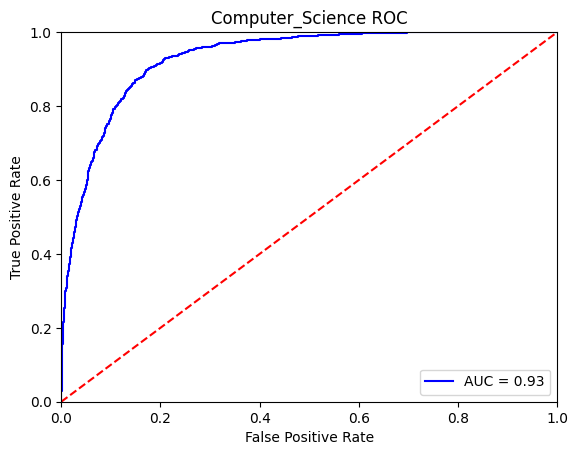

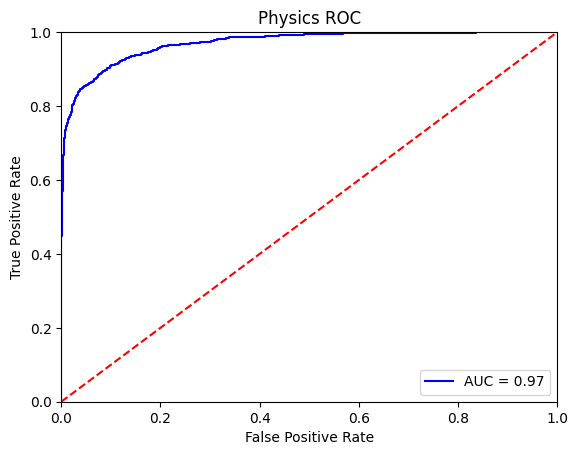

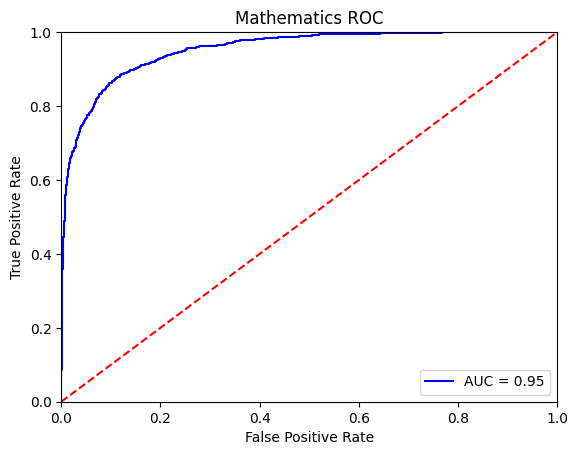

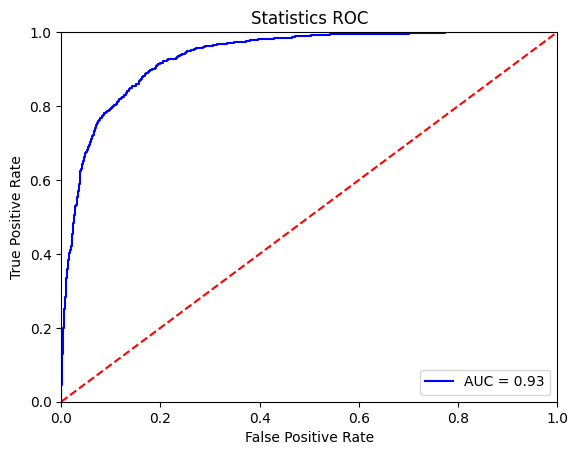

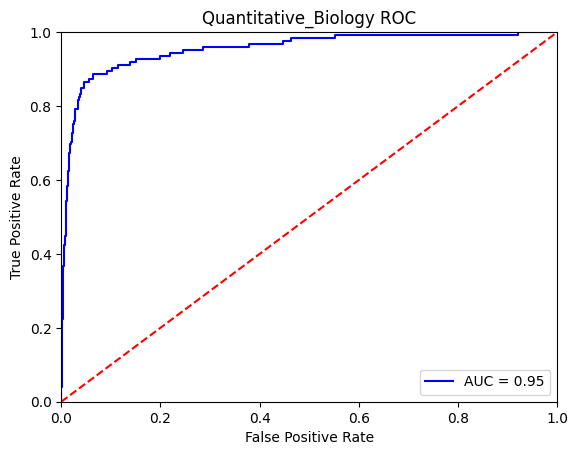

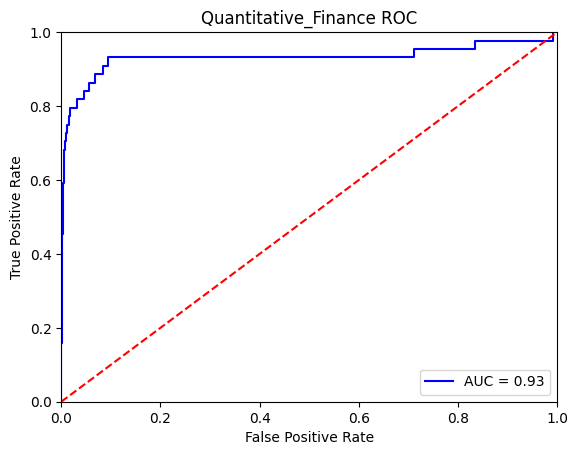

,topic,precision,recall,f1_score,accuracy,true negative,false positive,false negative,true positive,auc
0,Computer_Science,0.810568,0.849735,0.829689,0.857143,2110,337,255,1442,0.930580
1,Physics,0.897922,0.845238,0.870784,0.928813,2855,113,182,994,0.969807
2,Mathematics,0.827012,0.789753,0.807953,0.897442,2825,187,238,894,0.952616
3,Statistics,0.748588,0.778648,0.763322,0.881033,2856,267,226,795,0.934792
4,Quantitative_Biology,0.711538,0.296000,0.418079,0.975145,4004,15,88,37,0.954456
5,Quantitative_Finance,0.750000,0.409091,0.529412,0.992278,4094,6,26,18,0.931048


In [66]:
evaluate(val_data_with_pred, draw=True)

In [70]:
labels = ['Computer_Science', 'Physics', 'Mathematics', 'Statistics', 'Quantitative_Biology', 'Quantitative_Finance']
Y_pred_val = []
outputs = []
for i in tqdm.tqdm(range(259)):
    # print(f"{i*16} - {i*16+15}")
    pred = classifier_model(X_val[i*16:i*16+16])
    for p in pred:
        out = []
        for i,f in enumerate(p):
            if f>0.5:
                out.append(labels[i])
        outputs.append(out)
        Y_pred_val.append(p.numpy()) 

100%|██████████| 259/259 [00:24<00:00, 10.48it/s]


In [71]:
val_data_with_pred_10 = val_data.copy()
val_data_with_pred_10["output"] = outputs
val_data_with_pred_10["pred"] = Y_pred_val

In [72]:
val_data_with_pred_10.to_pickle("val_data_with_pred_10_epochs.pickle")

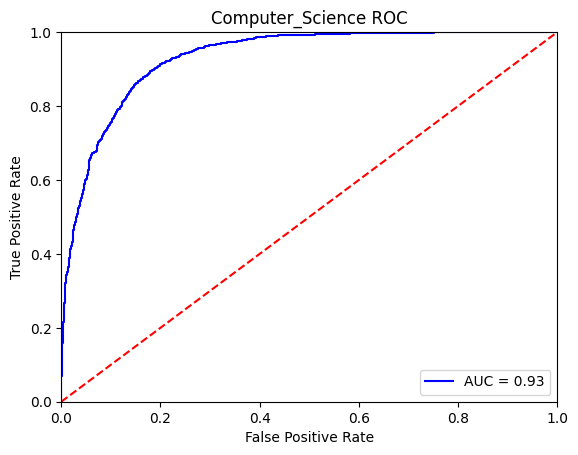

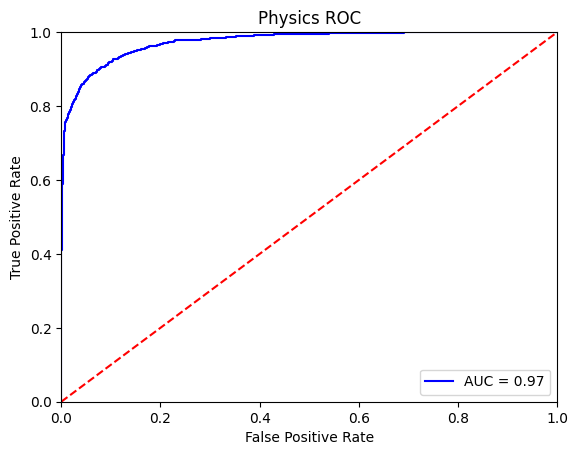

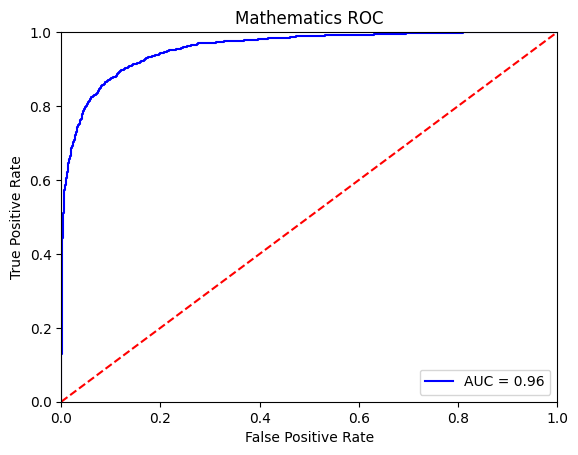

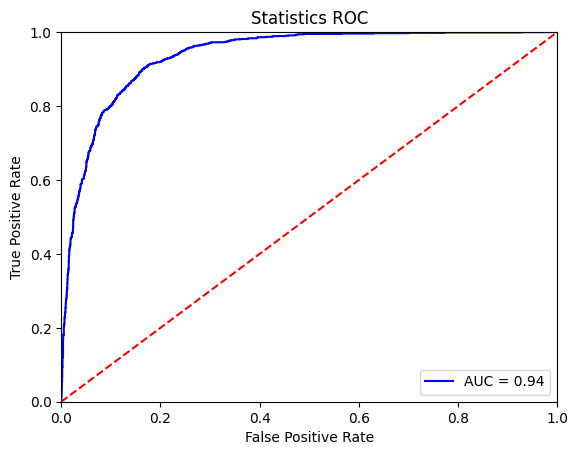

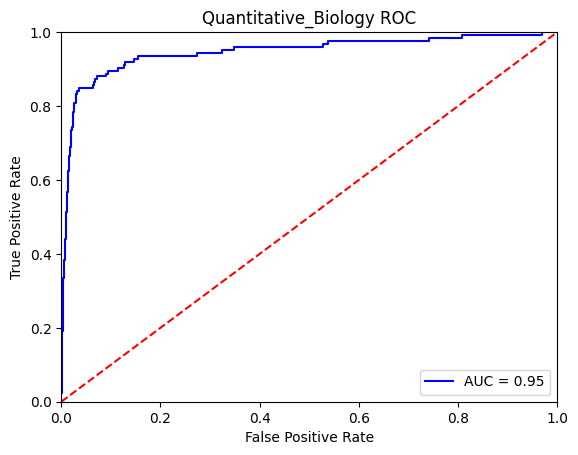

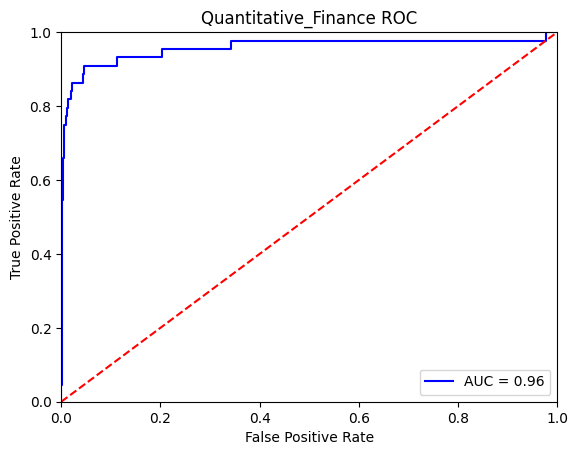

,topic,precision,recall,f1_score,accuracy,true negative,false positive,false negative,true positive,auc
0,Computer_Science,0.816677,0.813789,0.815230,0.848938,2137,310,316,1381,0.930871
1,Physics,0.915174,0.825680,0.868127,0.928813,2878,90,205,971,0.974399
2,Mathematics,0.853521,0.803004,0.827492,0.908542,2856,156,223,909,0.957303
3,Statistics,0.699588,0.832517,0.760286,0.870656,2758,365,171,850,0.937154
4,Quantitative_Biology,0.676923,0.352000,0.463158,0.975386,3998,21,81,44,0.946321
5,Quantitative_Finance,0.727273,0.545455,0.623377,0.993002,4091,9,20,24,0.957672


In [73]:
evaluate(val_data_with_pred_10, draw=True)